TEMAT 7.
ENTROPIA KRZYŻOWA – rozwiązanie metodą tabelarycznej entropii krzyżowej problemu ze 
środowiska CliffWalking-v0

Zasady:

Postać zaczyna w lewym dolnym rogu

Celem postaci jest dotarcie do punktu T, ktory jest w prawym dolnym rogu

Pomiędzy punktem początkowym, a T jest klif, wejście na klif powoduje śmierć postaci(powrót do miejsca początkowego)

Postać może poruszać się tylko w lewo, prawo, góre i dół

Postać nie może poruszać się na ukos

Wejście na klif powoduje utrate 100 punktów, a każdy inny ruch powoduje utrate 1 punktu

In [ ]:
import numpy as np #importuje biblioteki
import matplotlib.pyplot as plt
import gym
env = gym.make('CliffWalking-v0')

In [ ]:
env.reset()

36

In [ ]:
env.render()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [ ]:
env.action_space #ruchy w prawo, lewo, góra, dół

Discrete(4)

In [ ]:
env.observation_space #48 miejsc na planszy

Discrete(48)

In [ ]:
n_states = env.observation_space.n
n_actions = env.action_space.n

In [ ]:
#definiujemy polityke, dzięki której możemy otrzymać największą nagrode

def initialize_policy(n_states, n_actions):
  
    policy = np.zeros(shape=(n_states, n_actions)) +  1/n_actions #tworzy tablice, która na początku jest wypełniona zarami
    
    return policy

policy = initialize_policy(n_states, n_actions)

In [ ]:
def generate_session(env, policy, t_max = 2000):
  #t_maxymalna ilość sesji
  observations, actions = [], []
  total_reward = 0. #zaczynamy z 0 punktami
  observation = env.reset()
  
  for t in range(t_max):
    
    action = np.random.choice(n_actions, p = policy[observation]) #najpierw wybieramy losowy ruch

    new_observation, reward, done, info = env.step(action)

    observations.append(observation)
    actions.append(action) #wykonuje ruch
    total_reward += reward #nadpisuje ilość punktów po wykonaniu ruchu

    observation = new_observation #nadpisuje pozycje na którym się znajdujemy
    if done: #jeśli rozwiążemy problem kończymy
        break

  return observations, actions, total_reward #zakończenie wykonywania funkcji i zwraca podane wartości

In [ ]:
def select_elites(observations_batch, actions_batch, total_reward_batch, percentile):

    reward_threshold = np.percentile(total_reward_batch, percentile) #wybiera tylko te wyniki, które znajdują się powyżej określonego percyntylu

    elite_observations = []
    elite_actions = []

    for i in range(len(total_reward_batch)): #jeśli określony wynik będzie powyżej progu, to bierzemy go pod uwagę
      if total_reward_batch[i] >= reward_threshold: #próg reward_threshold jest zależny od percyntylu
        elite_observations += (observations_batch[i])
        elite_actions += (actions_batch[i])
        
    return elite_observations, elite_actions #zakończenie wykonywania funkcji i zwraca podane wartości

In [ ]:
#aktualizujemy polityke, tak by znalazły się w niej tylko elitarne wyniki

def update_policy(elite_observations, elite_actions):

    policy_updated = policy

    elite_observations_unique = set(elite_observations)
    
    actions_count = {observation:[0] * n_actions for observation in elite_observations_unique}

    for observation, action in zip(elite_observations, elite_actions):
        actions_count[observation][action] += 1
           
    for observation in elite_observations_unique:
        policy_updated[observation] = np.array(actions_count[observation]) / np.sum(actions_count[observation])

    return policy_updated #zakończenie wykonywania funkcji i zwraca podane wartości

In [ ]:
#zakładamy sposób ewaluacji problemu (ustalenie, czy projekt osiągnął zakładane cele)

from IPython.display import clear_output #importujemy biblioteke, żeby móc wyświetlić funkcje

def show_progress(rewards_batch, log, percentile): #wizualizacja treningu

    mean_reward = np.mean(rewards_batch) #wynik
    threshold = np.percentile(rewards_batch, percentile) #wynik biorąc pod uwagę tylko elite
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4]) #rozmiar wykresu
    plt.plot(list(zip(*log))[0], label='Mean rewards') #określamy fukcje, która będzie pokazywać średnie nagrody, w miare nauki
    plt.plot(list(zip(*log))[1], label='Reward thresholds') #określamy fukcje, która będzie pokazywać progi nagród, w miare nauki
    plt.legend() #pokazuje legende
    plt.grid() #pokazuje krate

    clear_output(True) #wyczyszczenie danych
    print("mean reward = ", mean_reward)
    print("treshold = ", threshold)
    plt.show()

In [ ]:
policy = initialize_policy(n_states, n_actions)

mean reward =  -13.0
treshold =  -13.0


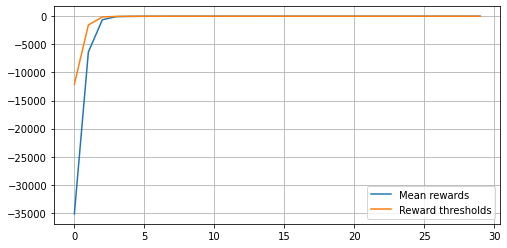

In [ ]:
#wyznaczamy hiperparamatry:
n_sessions = 250 #ilość sesji
percentile = 80 
learning_rate = 0.5 #szybkość uczenia

log = []

for i in range(30): #główna pętla w której wykonywane są wszystkie oblicznia/wykonujemy trening algorytmu
    sessions = [generate_session(env, policy, t_max=5000) for j in range(n_sessions)]
    
    observations_batch, actions_batch, total_reward_batch = zip(*sessions)

    elite_observations, elite_actions = select_elites(observations_batch, actions_batch, total_reward_batch, percentile)

    policy_updated = update_policy(elite_observations, elite_actions) #aktualizujemy polityke

    policy = learning_rate * policy_updated + (1 - learning_rate) * policy

    show_progress(total_reward_batch, log, percentile) #wizualizacja treningu

In [ ]:
print(policy)

[[0.         0.75       0.25       0.        ]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.18181818 0.81818182 0.         0.        ]
 [0.         0.64285714 0.35714286 0.        ]
 [0.         0.72727273 0.18181818 0.09090909]
 [0.         0.9        0.1        0.        ]
 [0.         0.81818182 0.18181818 0.        ]
 [0.125      0.625      0.25       0.        ]
 [0.09090909 0.54545455 0.36363636 0.        ]
 [0.125      0.875      0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.92307692 0.07692308 0.        ]
 [0.         0.75       0.25       0.        ]
 [0.         0.88888889 0.11111111 0.        ]
 [0.         0.5        0.5        0.        ]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.94117647 0.05882353 0.        ]
 [0.         

In [ ]:
total_reward = 0. #zaczynamy z 0 punktami
observation = env.reset()

for t in range(30): #ile maksymalnie możemy wykonać ruchów

  action = np.random.choice(n_actions, p = policy[observation]) #wykonanie ruchu zgodnie z polityką
  
  new_observation, reward, done, info = env.step(action)

  observation = new_observation #nadpisuje pozycje na którym się znajdujemy

  total_reward += reward #aktualizauje ilość punktów

  print(t, total_reward, done)
  env.render()
  if done:
    break #jeśli program dotrze do celu kończymy pętle

0 -1.0 False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

1 -2.0 False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

2 -3.0 False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  x  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

3 -4.0 False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

4 -5.0 False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  x  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

5 -6.0 False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  x  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T

6 -7.0 False
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o